In [6]:
import sys
root_dir = '/home/gddaslab/mxp140/tcr_project_ultimate'
sys.path.append(root_dir)

import h5py
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pdf import pdf, generate_configuration_per_tcr, ci_pdf, plot_pdf

def new_neg_likelihood(
    params, fixed_x1, clone_count_values, scaled_kr_values, verbose=False
):
    # params is now just x2, fixed_x1 is provided separately
    x2 = params[0]  # params is now a 1D array with just x2
    x1 = fixed_x1
    n = len(clone_count_values)
    x1_values = np.full(n, x1)
    x2_values = np.full(n, x2)
    probs = probability(x1_values, x2_values, scaled_kr_values, clone_count_values)
    # Replace zero values with the smallest positive value allowed in Python
    smallest_positive_value = np.finfo(float).eps
    probabilities = np.where(probs == 0, smallest_positive_value, probs)
    sum_log_probs = np.sum(np.log(probabilities))
    neg_sum = -sum_log_probs

    if verbose:
        print(f"Neg-logL: {neg_sum:.8f}")
        print(f"x2: {x2:.8f}")
        print(f"=" * 80)
    return neg_sum


def run_optimization(
    clone_count_values,
    scaled_kr_values,
    fixed_x1,
    bounds=((1e-10, 100),),
    initial_guess=[5],
    verbose=False,
):
    # Modified to take fixed_x1 parameter and only optimize x2
    bounds = [bounds[0]]  # Only bounds for x2
    initial_guess = initial_guess
    result = minimize(
        new_neg_likelihood,
        initial_guess,
        args=(fixed_x1, clone_count_values, scaled_kr_values, verbose),
        method="Nelder-Mead",
        bounds=bounds,
    )

    x2 = result.x[0]
    return fixed_x1, x2, initial_guess[0], result.fun

def calc_probs(kr, x1, x2, maxM):
    probabilities = [
        probability(x1, x2, kr, M) for M in range(1, maxM + 1)  # type: ignore
    ]
    return probabilities


def calc_probs_parallel(args):
    kr, x1, x2, maxM = args
    result = calc_probs(kr, x1, x2, maxM)
    return result

def generate_configuration_per_tcr(prob_array, size=1):
    config_per_tcr = np.random.choice(range(1, len(prob_array)+1), size=size, replace=True, p=prob_array/sum(prob_array))
    return config_per_tcr

In [9]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data.csv', sep=',')

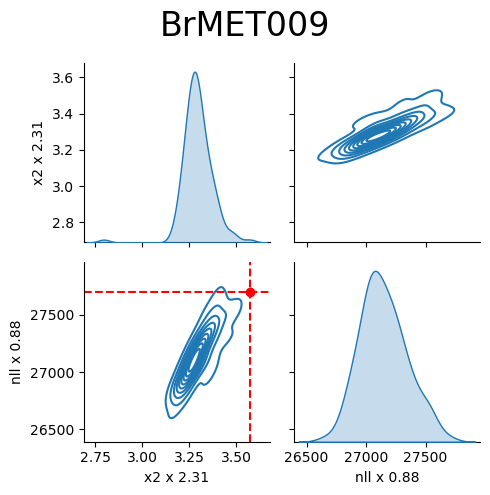

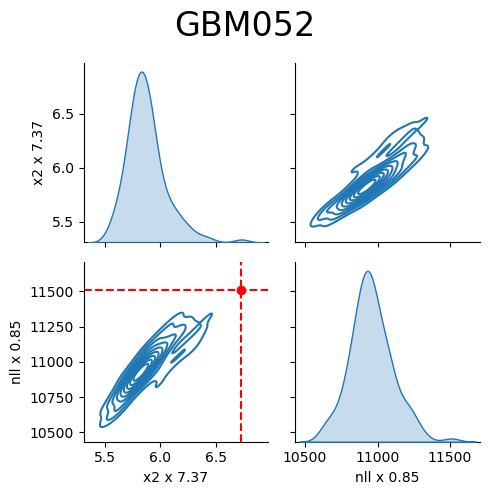

In [10]:
patients = ['BrMET009', 'GBM052']
for patient_id in patients:
    all_uniform_kr_data = np.load(f"{root_dir}/results/uniform_dists.npz")
    uniform_scaled_kr_values = all_uniform_kr_data[patient_id]
    all_uniform_kr_data.close()  # close the file to free memory
    old_parameters_df = pd.read_csv(f'{root_dir}/results/parameters.csv')
    new_parameters_df = pd.read_csv(f'{root_dir}/results/{patient_id}_uniform_kr_test_params.csv')
    reference_x2 = old_parameters_df[old_parameters_df['Patient'].str.contains(patient_id)]['x2'].values[0]
    reference_nll = old_parameters_df[old_parameters_df['Patient'].str.contains(patient_id)]['nll'].values[0]
    current_max_x2 = new_parameters_df['x2'].max()
    scaling_factor_x2 = reference_x2 / current_max_x2
    new_parameters_df[f'x2 x {scaling_factor_x2:.2f}'] = new_parameters_df['x2'] * scaling_factor_x2
    current_max_nll = new_parameters_df['nll'].max()
    scaling_factor_nll = reference_nll / current_max_nll
    new_parameters_df[f'nll x {scaling_factor_nll:.2f}'] = new_parameters_df['nll'] * scaling_factor_nll
    pairplot = sns.pairplot(new_parameters_df, vars= [f'x2 x {scaling_factor_x2:.2f}', f'nll x {scaling_factor_nll:.2f}'], kind='kde')
    # Adding the reference value as a red point
    pairplot.axes[1][0].plot(reference_x2, reference_nll, 'ro')
    pairplot.axes[1][0].axhline(reference_nll, color='red', linestyle='--')
    pairplot.axes[1][0].axvline(reference_x2, color='red', linestyle='--')
    # Correcting the title for the entire figure
    pairplot.figure.suptitle(f'{patient_id}', fontsize=24)
    plt.tight_layout()
    plt.show()

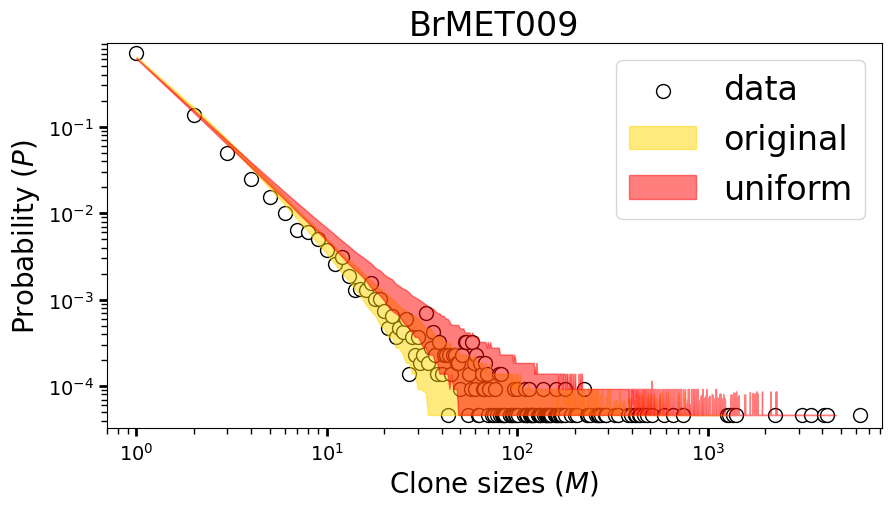

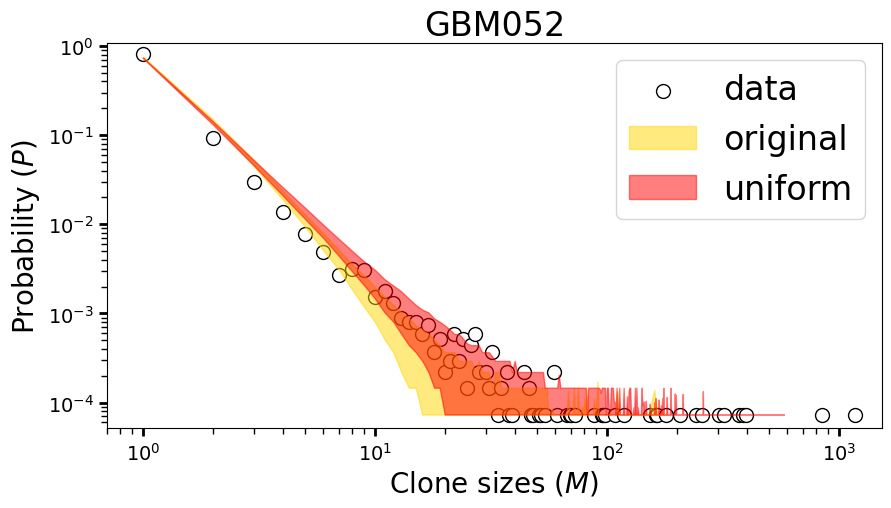

In [20]:
for patient_id in patients[:]:
    try:
        with h5py.File(f'{root_dir}/results/probabilities/probs_{patient_id}.h5', 'r') as f:
            probs = f['result'][:]
            # print(f'{patient_id}:{probs.shape}')
        size=1000
        all_configs = np.empty((probs.shape[0], size))
        for i in tqdm.tqdm(range(probs.shape[0]), total=probs.shape[0], desc=f'{patient_id}: Generating configuration for every TCR', leave=False):
            config_per_tcr = generate_configuration_per_tcr(probs[i, :], size=size)
            all_configs[i, :] = config_per_tcr
        
        patient_data = full_data[full_data["Patient"]==patient_id]
        clone_count_values = patient_data['counts']
        n = len(clone_count_values)
        fig, ax = plot_pdf(clone_count_values)
        
        ci_df = ci_pdf(all_configs, least_number_of_observations=5)
        ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='gold', alpha=0.5, zorder=2, label='original')
        # ax.plot(ci_df['clone_size'], ci_df['median'], color='r', marker='x', alpha=1.)
        
        ################### for uniform kr ############
        with h5py.File(f'{root_dir}/results/probabilities/probs_{patient_id}_uni0_test.h5', 'r') as f:
            probs = f['result'][:]
            # print(f'{patient_id}:{probs.shape}')
        all_configs = np.empty((probs.shape[0], size))
        for i in tqdm.tqdm(range(probs.shape[0]), total=probs.shape[0], desc=f'{patient_id}: Generating configuration for every TCR', leave=False):
            config_per_tcr = generate_configuration_per_tcr(probs[i, :], size=size)
            all_configs[i, :] = config_per_tcr
        ci_df = ci_pdf(all_configs, least_number_of_observations=5)
        ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='red', alpha=0.5, zorder=3, label='uniform')
        
        ax.set_title(f'{patient_id}', fontsize=24)
        ax.legend(loc='best', fontsize=24)
        ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20)
        ax.set_ylabel('Probability ($P$)', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
        ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)
        plt.show()
    except:
        print(f"File not found for patient {patient_id}")